In [1]:
# Imports
import numpy as np
import xarray as xr
from minisom import MiniSom
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from itertools import product
import itertools

In [2]:
dataset = xr.open_dataarray('data/Z500Anoms_ERA5_v2.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(200, 310) #160W, 50W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

#dataset = xr.open_dataset('Z500_ERA5.nc')

In [3]:
print(dataarray.shape)


(30681, 6771)


In [4]:
def calc_som_corr(som, shape):
    neurons = list(product(range(shape[0]), range(shape[1])))
    wm = {neuron: [] for neuron in neurons}
    avgs = {neuron: [] for neuron in neurons}
    
    # sort the data into their winning neurons
    for i, x in enumerate(dataarray):
        wm[som.winner(x)].append(i)
        
    # calculate the average of each neuron
    for i in range(len(neurons)):
        avgs[neurons[i]] = dataset.sel(lat=latSlice, lon=lonSlice)[wm[neurons[i]]].mean(dim='time', skipna=True).stack(latlon=['lat', 'lon']).values
        
    # find each days correlation with respect to the average of its neuron
    averagesList = []
    for i in dataarray:
        averagesList.append(avgs[som.winner(i)])
        
    corr = []
    for i in range(len(dataarray)):
        corr.append(np.corrcoef(dataarray[i], averagesList[i])[0, 1])
    
    return sum(corr) / len(corr)

### HEXAGON SOM PARAMETER FITTING

In [11]:
def create_hex_plot(x_neurons, y_neurons, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # create figure
    fig_width = 1
    fig_height = 1
    fig = plt.figure(figsize=[(x_neurons * fig_width) + (fig_width/2), y_neurons * fig_height])
    axs = {}
    
    for x, y in list(product(range(x_neurons), range(y_neurons))):
        
        # odd rows will be offset to keep the hexagonal shape
        if y % 2 == 0:
            left = x * fig_width
        else:
            left = (x * fig_width) + (fig_width/2)   
        
        bottom = y * fig_height

        ax = fig.add_axes([left, bottom, fig_width, fig_height], projection=projection)
        ax.set_title((x, y))
        axs[(x, y)] = ax
        
    return fig, axs

In [14]:
def train_som(rows, cols, sigma, learning_rate, decay_function, neighborhood_function, topology, seed, iters):
    
    som = MiniSom(rows, cols, dataarray.shape[1], sigma=sigma, learning_rate=learning_rate, 
                     neighborhood_function=neighborhood_function, decay_function=decay_function, 
                     random_seed=seed, topology=topology)
    som.random_weights_init(dataarray)
    som.train(dataarray, iters, True)
    
    return som

def make_hex_frequency_plot(som, winmap=None):
    
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    if winmap == None:
        winmap = som.win_map(dataarray)
    maxCount = max(len(v) for v in winmap.values())
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # determine the hexagon position and color
            wy = yy[(i, j)] * np.sqrt(3) / 2
            colorWeight = len(winmap[(i, j)])/maxCount
            
            # Create hexagon and add it to axis
            hex = patches.RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                     facecolor=colormaps['Blues'](colorWeight), edgecolor='grey')
            ax.add_patch(hex)
            
            # add text to hexagon for its frequency
            plt.text(xx[(i, j)], wy, f'Count: {len(winmap[(i, j)])} {i}, {j}', {'horizontalalignment': 'center'})

    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    plt.xticks([])
    plt.yticks([])

    plt.title('Hexagon SOM Frequencies')
    
    return fig

def make_hex_composite_map(som, winmap=None):
    fig, axs = create_hex_plot(5, 5)

    lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
    lons = dataset.sel(lat=latSlice, lon=lonSlice).lon
    
    if winmap == None:
        winmap = som.win_map(dataarray)

    # calculate the average of eacah of the nodes
    neurons = list(winmap.keys())
    somAvgs = {neuron: [] for neuron in neurons}
    for i in range(len(neurons)):
        somAvgs[neurons[i]] = dataset[winmap[neurons[i]]].mean(dim='time', skipna=True)

    for neuron in neurons:
        avgs = somAvgs[neuron].sel(lat=latSlice, lon=lonSlice)
        
        axs[neuron[0], neuron[1]].pcolormesh(lons, lats, avgs, cmap='seismic', transform=ccrs.PlateCarree())
        
        axs[neuron[0], neuron[1]].set_title(f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
        
        # background map features
        axs[neuron[0], neuron[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        axs[neuron[0], neuron[1]].margins(x=0, y=0)
        axs[neuron[0], neuron[1]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
        axs[neuron[0], neuron[1]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

    return fig

def one_iter():
    #som = train_som()
    # HYPERPARAMETERS
    row_neurons = 5
    col_neurons = 5
    inputLength = dataarray.shape[1]
    sigma = 4
    learning_rate = .5
    decay_function = 'asymptotic_decay'
    neighborhood_function = 'gaussian'
    topology = 'hexagonal'
    random_seed = 28

    # TRAINING
    som = MiniSom(row_neurons, col_neurons, inputLength, sigma=sigma, learning_rate=learning_rate, neighborhood_function=neighborhood_function,
                decay_function=decay_function, random_seed=random_seed, topology=topology)
    som.random_weights_init(dataarray)
    som.train(dataarray, 10000, True)
    
    qerror = som.quantization_error(dataarray)
    terror = som.topographic_error(dataarray)
    
    fig = make_hex_frequency_plot(som)
    plt.savefig('SOM1_frequencies.png')
    
    fig = make_hex_composite_map(som)
    plt.savefig('SOM1_frequencies.png')
    
    print(qerror)
    print(terror)
    
    

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: time

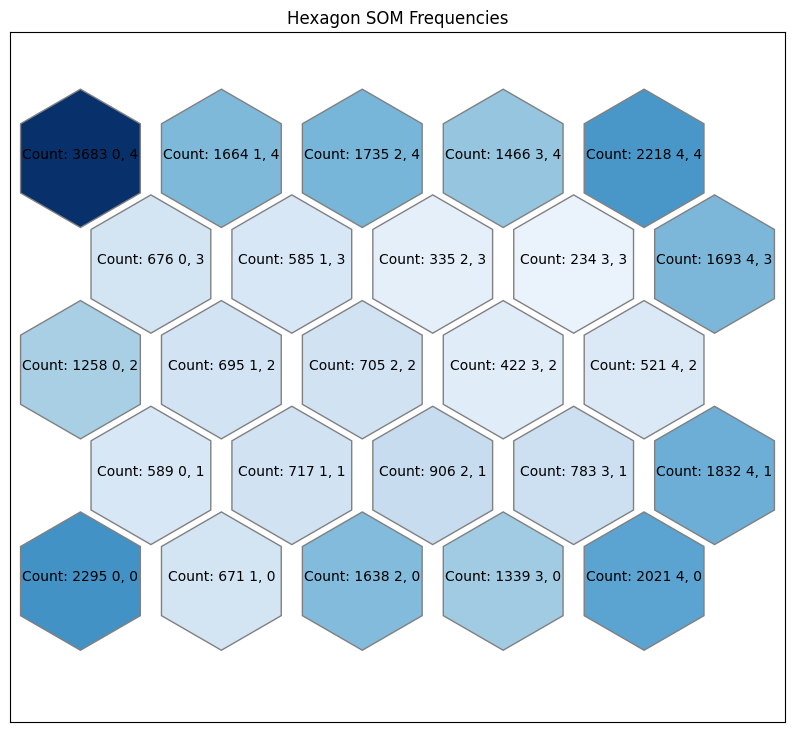

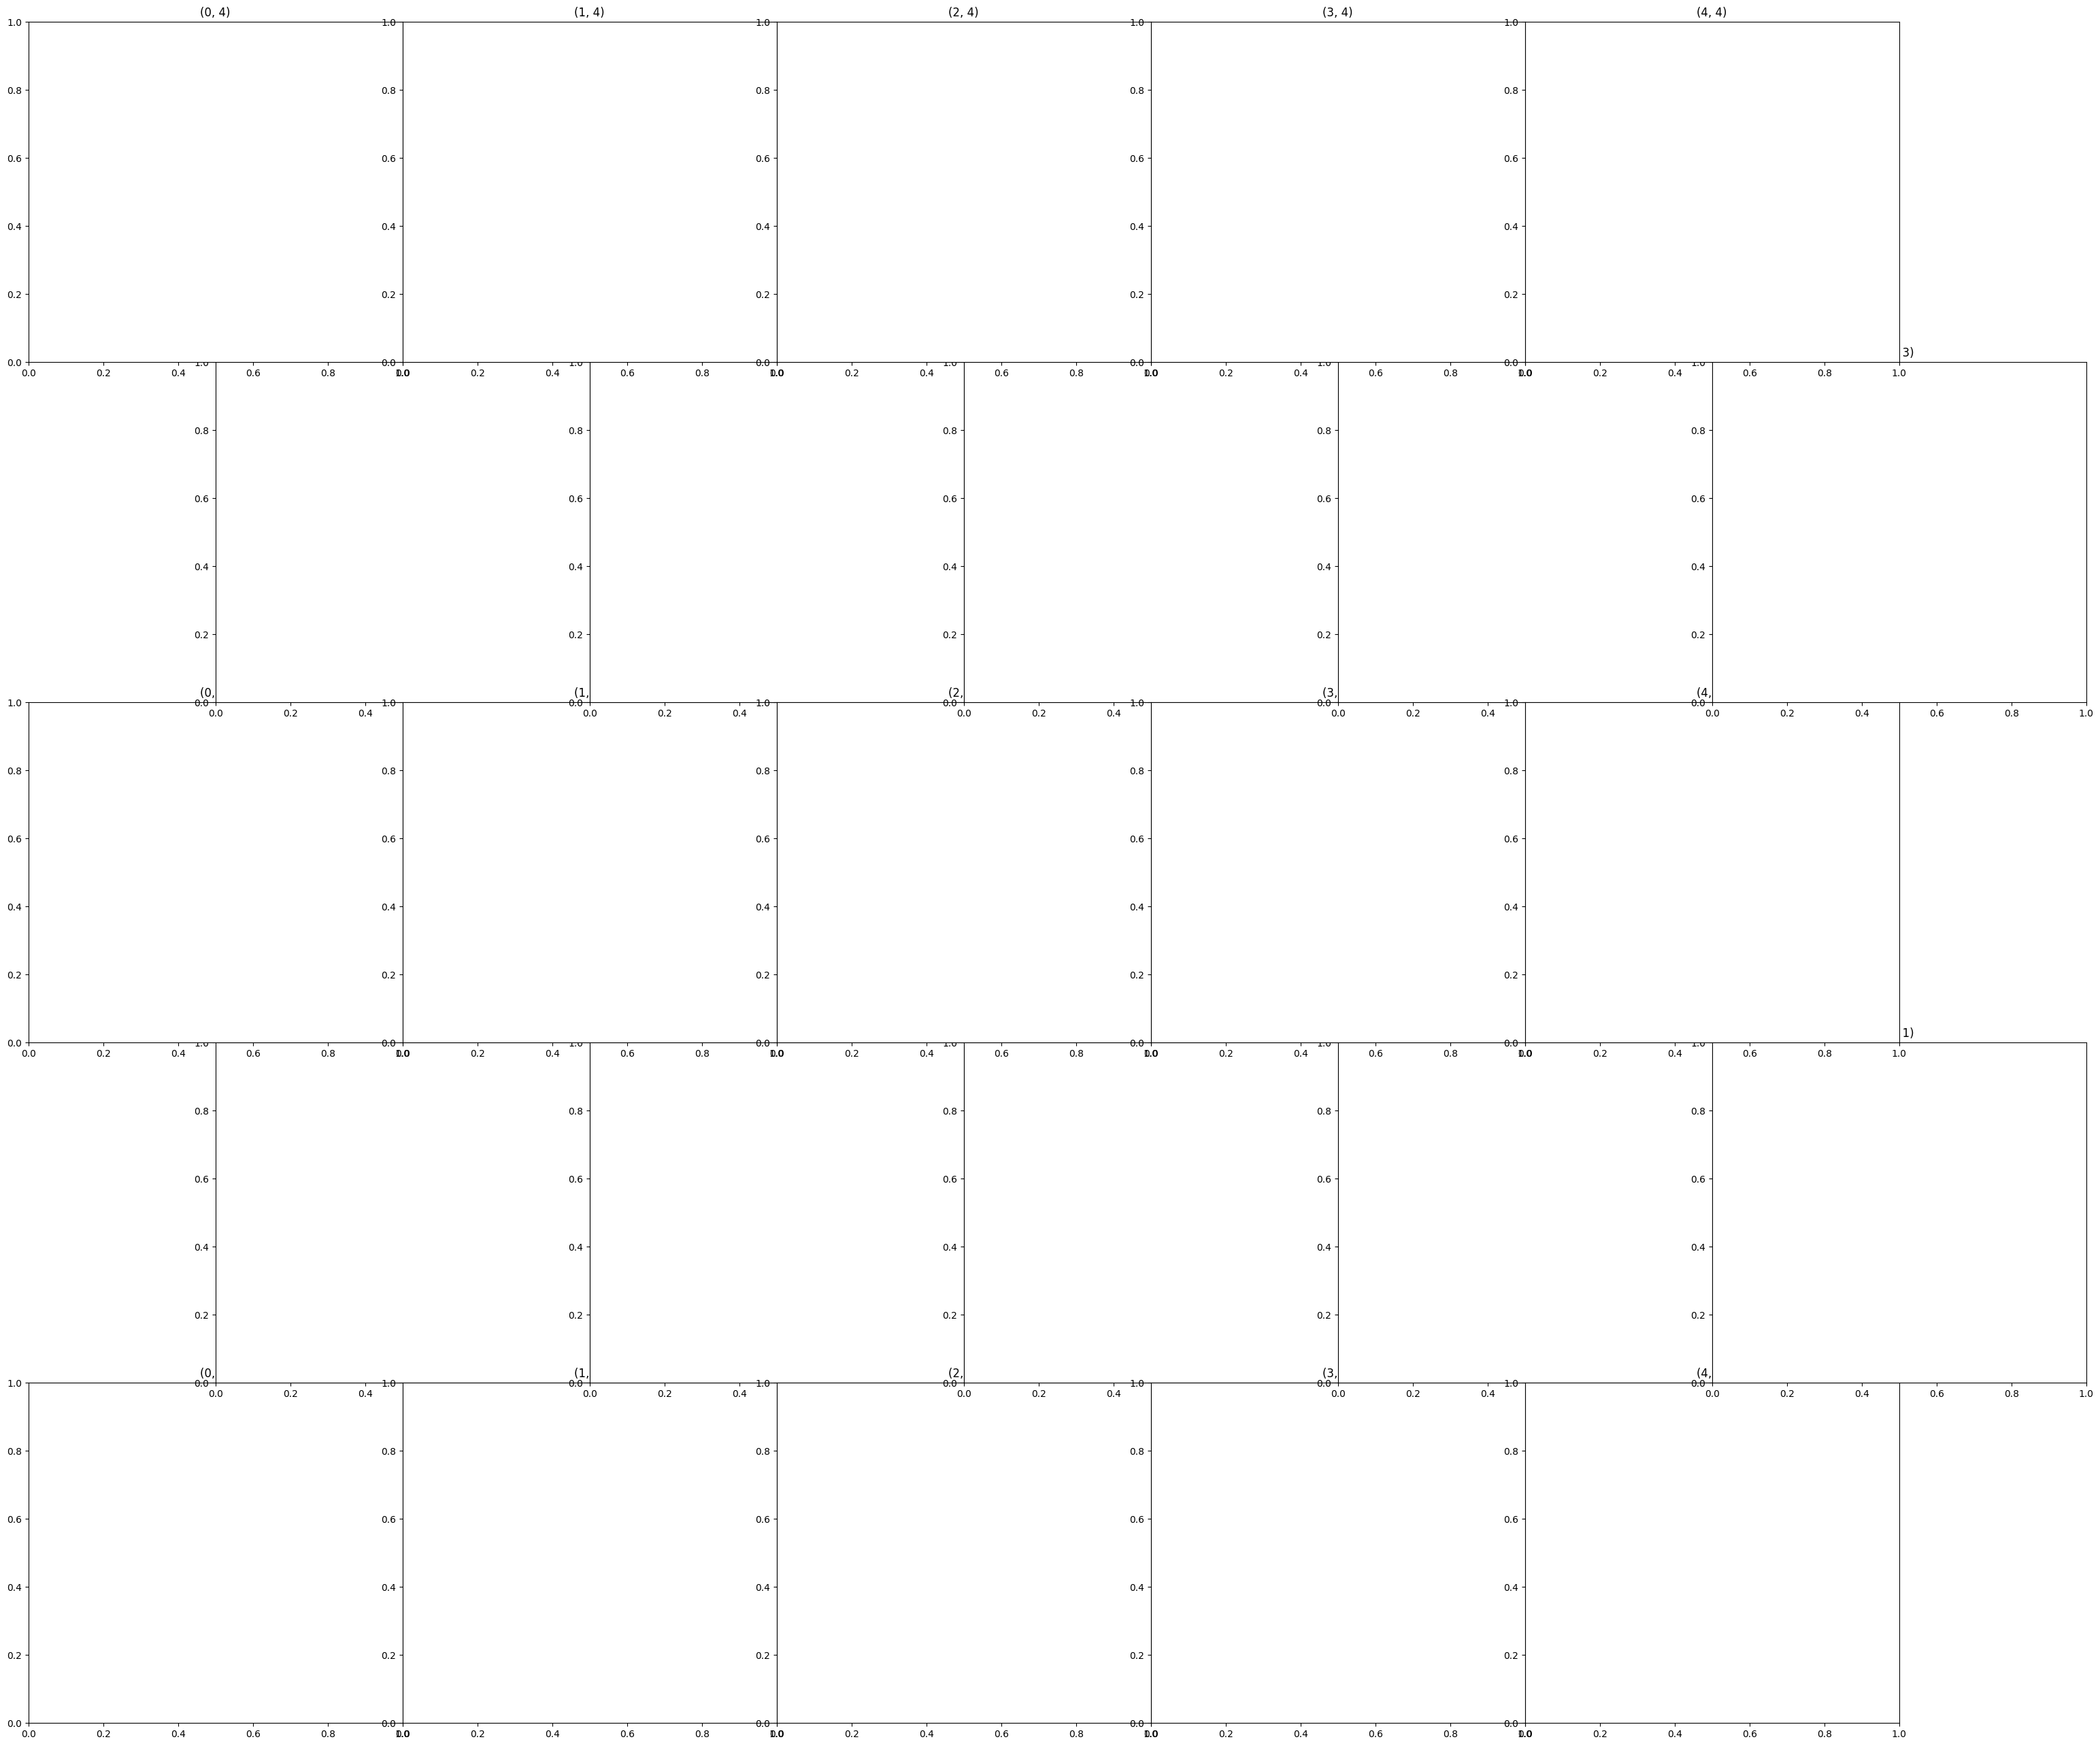

: 

In [15]:
one_iter()

### HEXAGON TRAINING

In [6]:
# HYPERPARAMETERS
row_neurons = 5
col_neurons = 5
inputLength = dataarray.shape[1]
sigma = 4
learning_rate = .5
decay_function = 'asymptotic_decay'
neighborhood_function = 'gaussian'
topology = 'hexagonal'
random_seed = 28

# TRAINING
hexsom = MiniSom(row_neurons, col_neurons, inputLength, sigma=sigma, learning_rate=learning_rate, neighborhood_function=neighborhood_function,
              decay_function=decay_function, random_seed=random_seed, topology=topology)
hexsom.random_weights_init(dataarray)
hexsom.train(dataarray, 10000, True)

In [7]:
xx, yy = hexsom.get_euclidean_coordinates()
weights = hexsom.get_weights()
neurons = list(product(range(row_neurons), range(col_neurons)))
winmap = hexsom.win_map(dataarray)
wincount = hexsom.activation_response(dataarray)

maxCount = wincount.max()

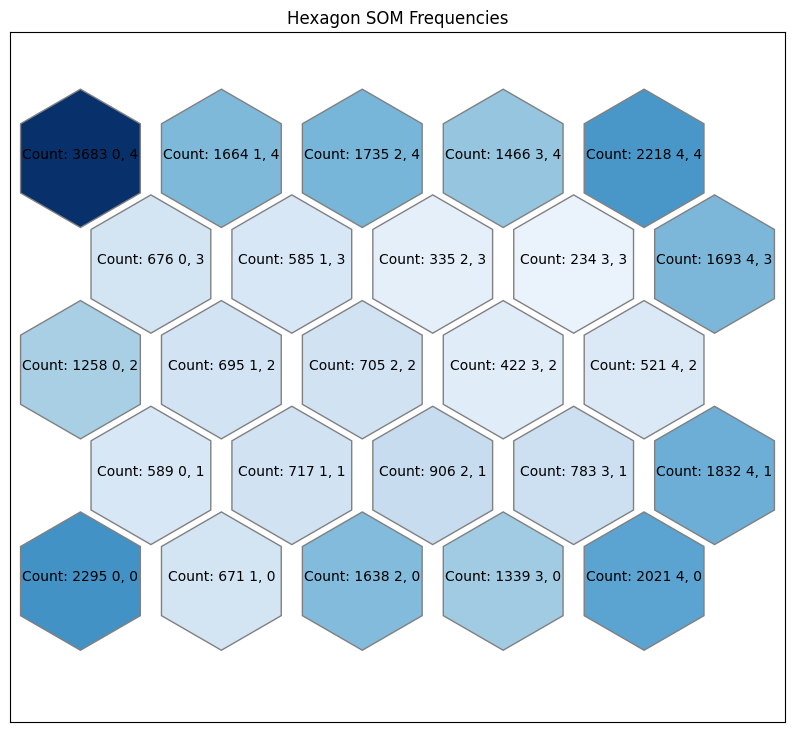

"f = plt.figure(figsize=(10,10))\nax = f.add_subplot(111)\nax.set_aspect('equal')\n\n# add all of the hexagons to the plot\nfor i in range(weights.shape[0]):\n    for j in range(weights.shape[1]):\n        wy = yy[(i, j)] * np.sqrt(3) / 2\n        colorWeight = len(winmap[(i, j)])/maxCount\n        hex = patches.RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.85 / np.sqrt(3), \n                                     facecolor=colormaps['Blues'](colorWeight), edgecolor='grey')\n        \n        ax.add_patch(hex)\n        \n        # add the text in each hexagon for its frequency\n        plt.text(xx[(i, j)], wy, f'Count: {len(winmap[(i, j)])} {i}, {j}', {'horizontalalignment': 'center'})\n        \nplt.xlim(-1, weights.shape[0] - .5)\nplt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)\nplt.xticks([])\nplt.yticks([])\n\nplt.title('Hexagon SOM Frequencies')\nplt.show()"

In [8]:
fig = make_hex_frequency_plot(hexsom)
plt.show()

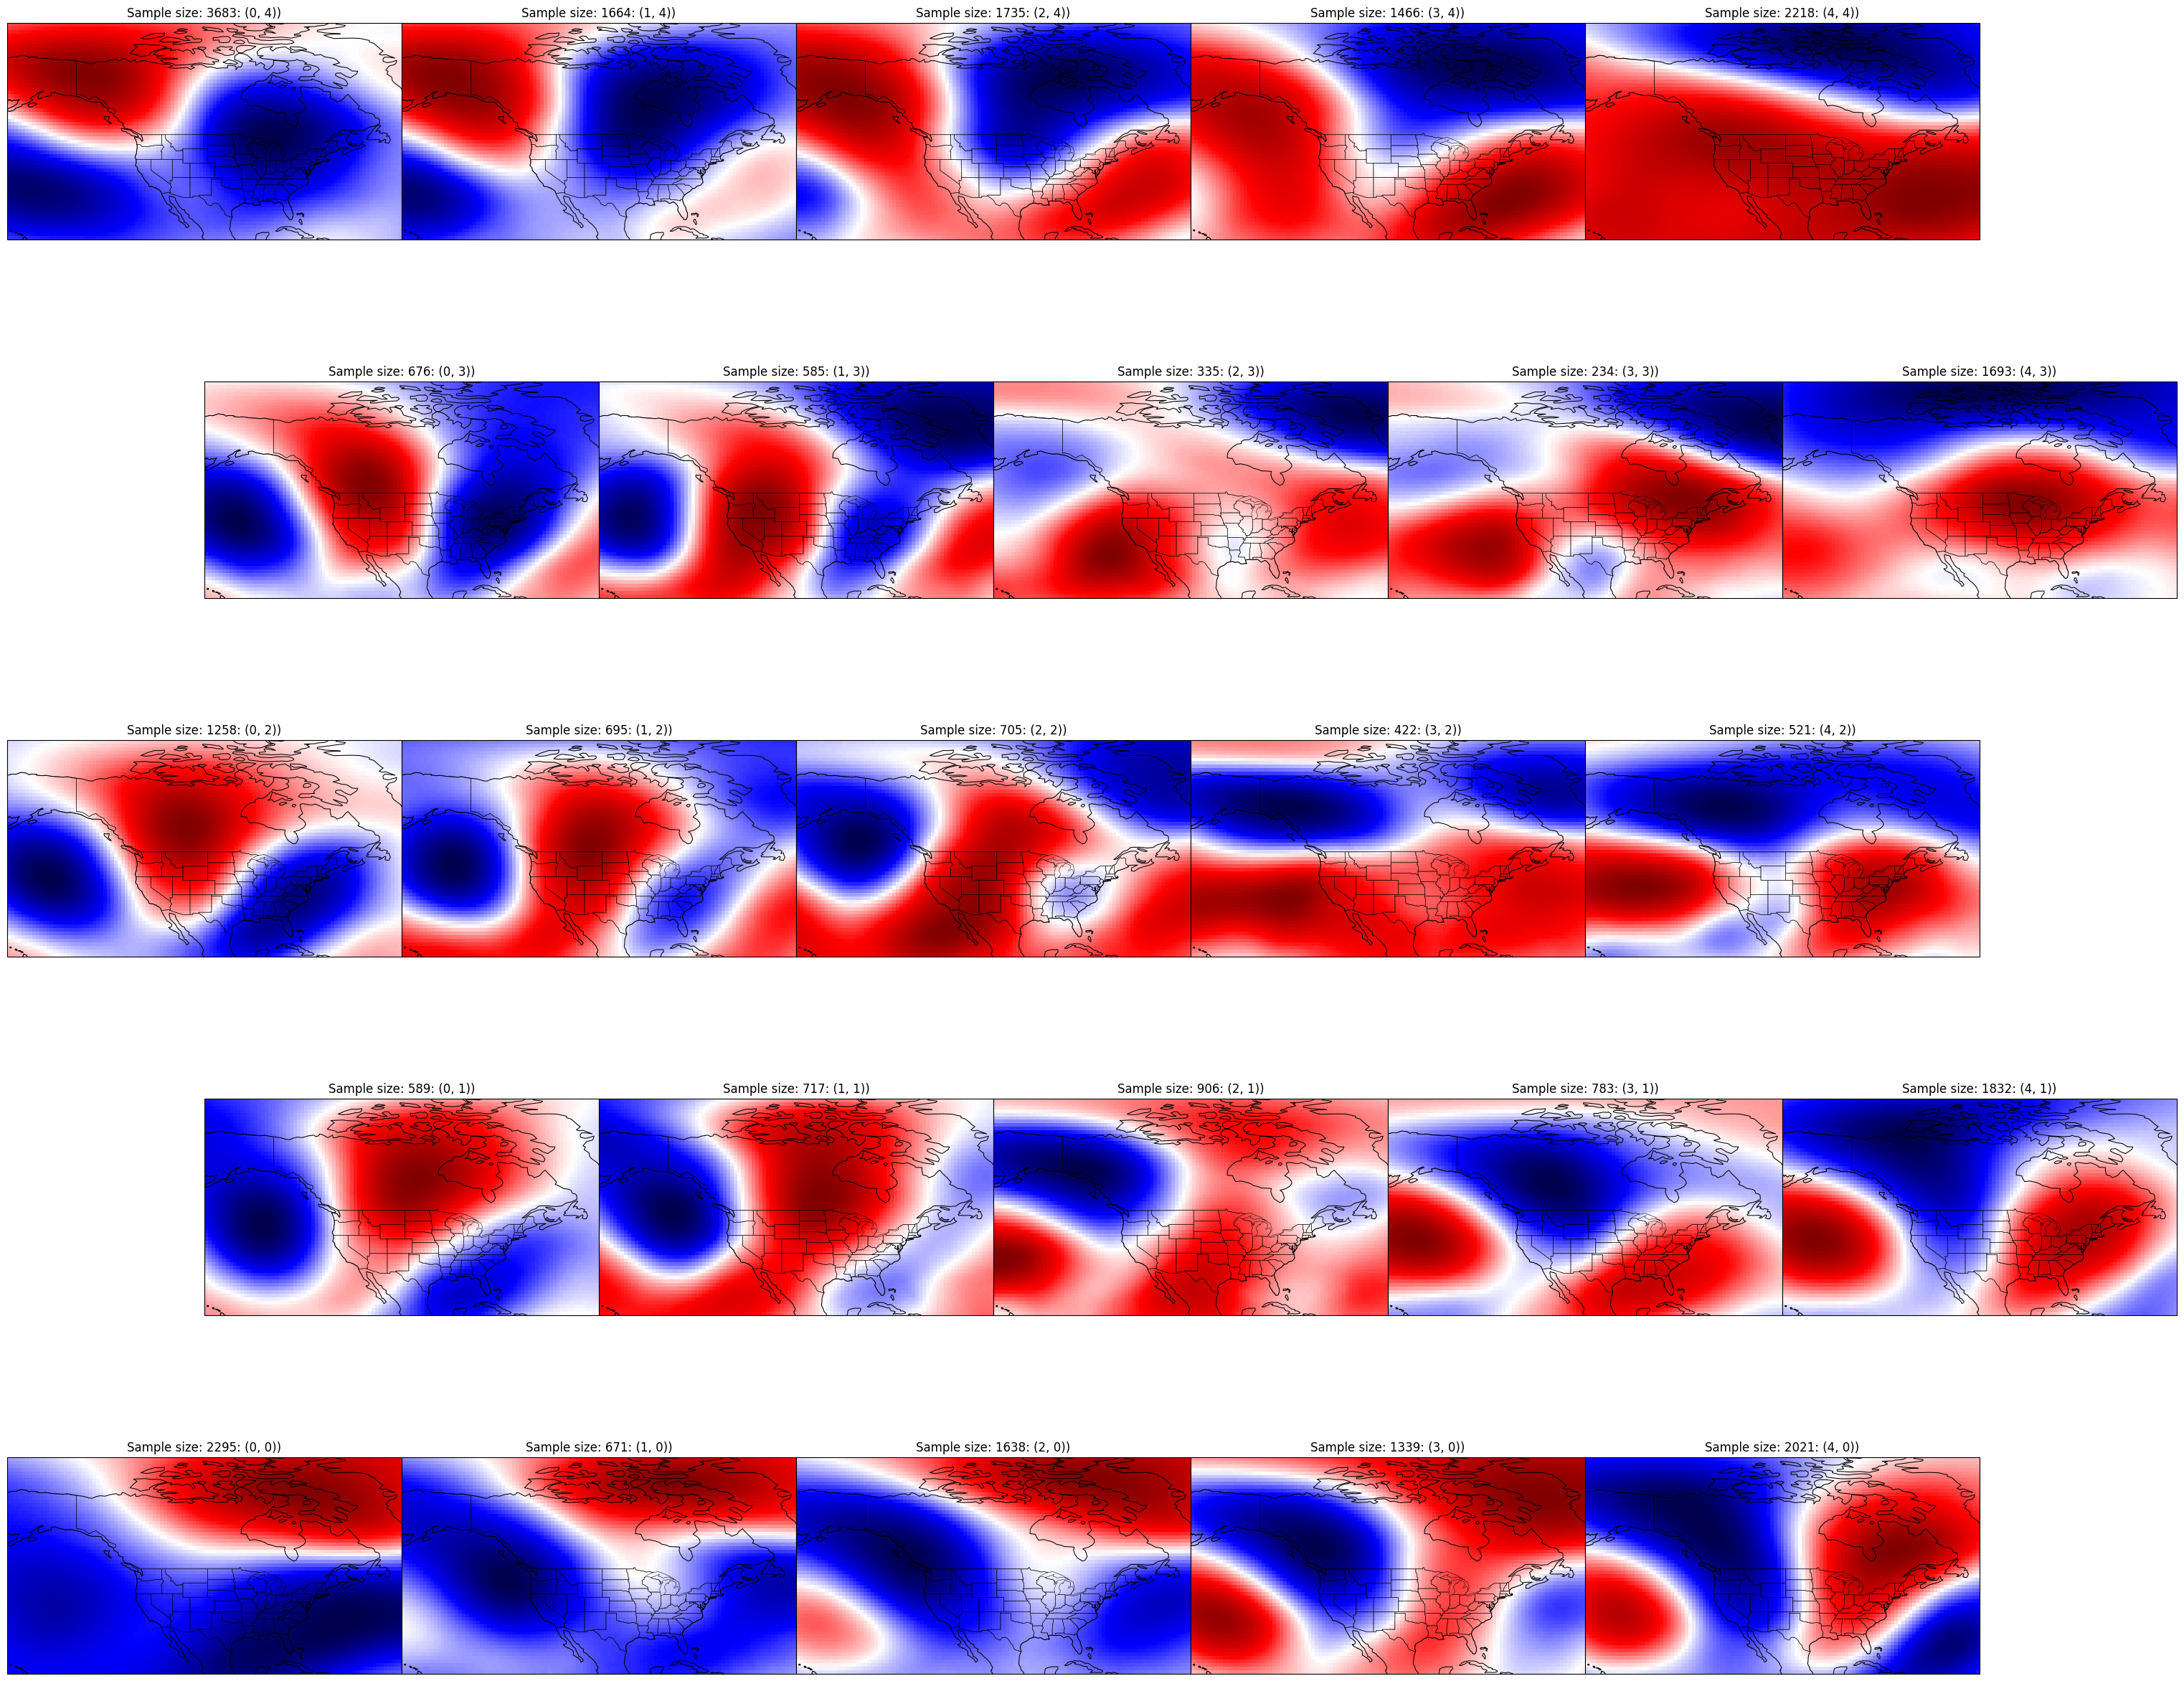

In [26]:
fig, axs = create_hex_plot(5, 5, ccrs.PlateCarree())

lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon

# calculate the average of eacah of the nodes
somAvgs = {neuron: [] for neuron in neurons}
for i in range(len(neurons)):
    somAvgs[neurons[i]] = dataset[winmap[neurons[i]]].mean(dim='time', skipna=True)

for neuron in neurons:
    avgs = somAvgs[neuron].sel(lat=latSlice, lon=lonSlice)
    
    axs[neuron[0], neuron[1]].pcolormesh(lons, lats, avgs, cmap='seismic', transform=ccrs.PlateCarree())
    
    axs[neuron[0], neuron[1]].set_title(f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
    
    # background map features
    axs[neuron[0], neuron[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[neuron[0], neuron[1]].margins(x=0, y=0)
    axs[neuron[0], neuron[1]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
    axs[neuron[0], neuron[1]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

plt.show()

In [27]:
error = hexsom.topographic_error(dataarray)

In [28]:
print(error)

0.0671099377464881


### RECTANGULAR TRAINING

In [6]:
# HYPERPARAMETERS

n_neurons = 3
m_neurons = 3
inputLength = dataarray.shape[1]
sigma = 1.4
learning_rate = .5
decay_function = 'asymptotic_decay'
neighborhood_function = 'gaussian'
random_seed = 28

# TRAINING
som = MiniSom(n_neurons, m_neurons, inputLength, sigma=sigma, learning_rate=learning_rate, neighborhood_function=neighborhood_function,
              decay_function=decay_function, random_seed=random_seed)

som.random_weights_init(dataarray)
som.train(dataarray, 10000, True)

In [7]:
neurons = list(product(range(n_neurons), range(m_neurons)))
winmap = {neuron: [] for neuron in neurons}
somAvgs = {neuron: [] for neuron in neurons}

# store the indicies with the winner neurons
for i, x in enumerate(dataarray):
    winmap[som.winner(x)].append(i)
    
# calculate the average of eacah of the nodes
for i in range(len(neurons)):
    somAvgs[neurons[i]] = dataset[winmap[neurons[i]]].mean(dim='time', skipna=True)


In [8]:
# plot correlation histogram
somCorrelations = {neuron: [] for neuron in neurons}

for neuron in winmap:
    for idx in winmap[neuron]:
        day = dataarray[idx]
        avg = somAvgs[neuron].sel(lat=latSlice, lon=lonSlice).stack(latlon=['lat', 'lon']).values
        
        somCorrelations[neuron].append(np.corrcoef(day, avg)[0, 1])
        
print(somCorrelations)

{(0, 0): [0.1034981888350219, 0.1957072928407486, 0.27847756446539984, 0.3289692931739311, 0.5826988651905879, 0.6570735171990119, 0.6694872408865965, 0.5951835034148971, 0.45385397651920295, 0.4844467452797239, 0.46218706500580675, 0.23432902268506856, 0.6074278847310598, 0.6678355851311533, 0.669275357224204, 0.6343032912523262, 0.5961602082717811, 0.5728126615450059, 0.5687014816204771, 0.5798272385709878, 0.5955180483264931, 0.6037518201311857, 0.5996424538858279, 0.5844864786653, 0.24780206168163607, 0.24776310189508044, 0.2697423515566729, 0.42379433902620334, 0.4367736896509982, 0.44054907628882234, 0.4414824779263947, 0.43925031712858953, 0.4249394282396606, 0.4552625023924569, 0.4783279185653289, 0.40188500969072366, 0.47929076584464786, 0.4765869673500517, 0.5465637030511823, 0.5589765276909536, 0.3902005480665134, 0.4363004486454039, 0.4023460965519885, 0.34675759195115746, 0.4409031182883621, 0.49878254888961343, 0.5209404602727878, 0.5081727785082588, 0.37978229954811915, 

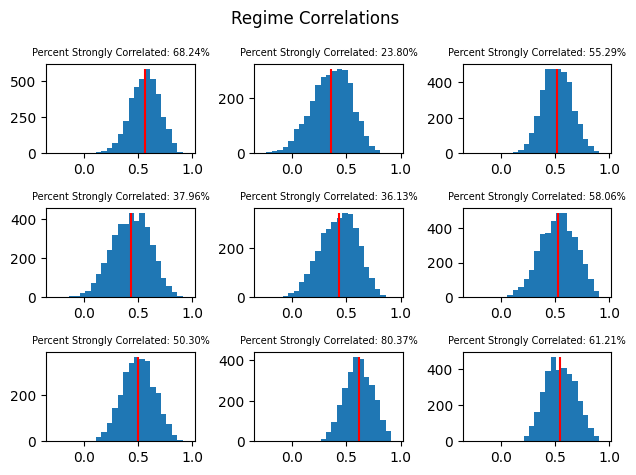

In [15]:
fig, axs = plt.subplots(n_neurons, m_neurons)
maxCorr = max(sum(somCorrelations.values(), []))
minCorr = min(sum(somCorrelations.values(), []))

for i in range(len(neurons)):
    correlations = somCorrelations[neurons[i]]
    curAx = axs[neurons[i][0], neurons[i][1]]
    
    strongCorr = [c for c in correlations if c > .5]
    strongCorr = (len(strongCorr) / len(correlations)) * 100
    mean = np.mean(correlations)
    
    count, bins, patches = curAx.hist(correlations, bins=np.arange(minCorr, 1, .05), range=(minCorr, maxCorr))
    curAx.vlines(mean, 0, max(count), label='Mean', color='r')
    #curAx.text(mean + 1.5, max(count) - max(count)/5, f'Mean: {mean:.2f}', fontsize=7)
    curAx.set_title(f'Percent Strongly Correlated: {strongCorr:.2f}%', fontsize=7)
    
fig.suptitle('Regime Correlations')
plt.tight_layout()
plt.show()

241832.66666666666


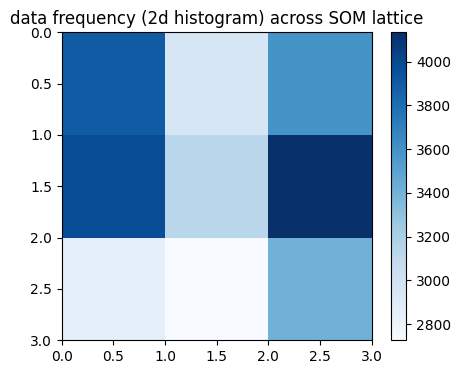

In [24]:
plt.figure(figsize=(5, 4))
frequencies = som.activation_response(dataarray)
print(np.var(frequencies))
plt.pcolormesh(frequencies, cmap='Blues')
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(n_neurons, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

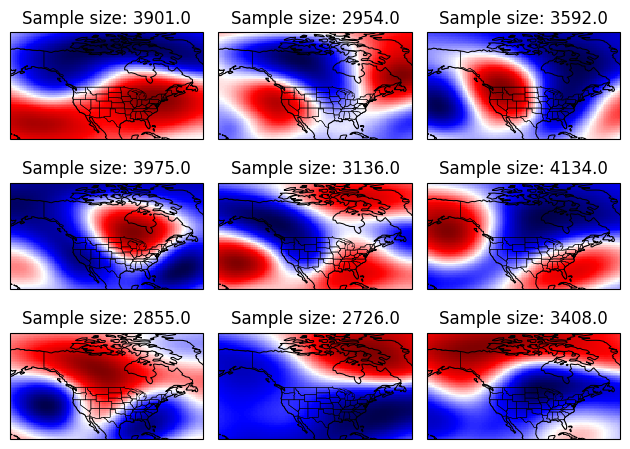

In [25]:
fig, axs = plt.subplots(n_neurons, m_neurons, subplot_kw=dict(projection=ccrs.PlateCarree()))
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon

for i in range(len(neurons)):
    avgs = somAvgs[neurons[i]].sel(lat=latSlice, lon=lonSlice)
    
    axs[neurons[i][0], neurons[i][1]].pcolormesh(lons, lats, avgs, cmap='seismic', transform=ccrs.PlateCarree())
    
    axs[neurons[i][0], neurons[i][1]].set_title(f"Sample size: {frequencies.flatten()[i]}", fontsize=12)
    
    # background map features
    axs[neurons[i][0], neurons[i][1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[neurons[i][0], neurons[i][1]].margins(x=0, y=0)
    axs[neurons[i][0], neurons[i][1]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
    axs[neurons[i][0], neurons[i][1]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
    
plt.tight_layout()
plt.show()

In [50]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

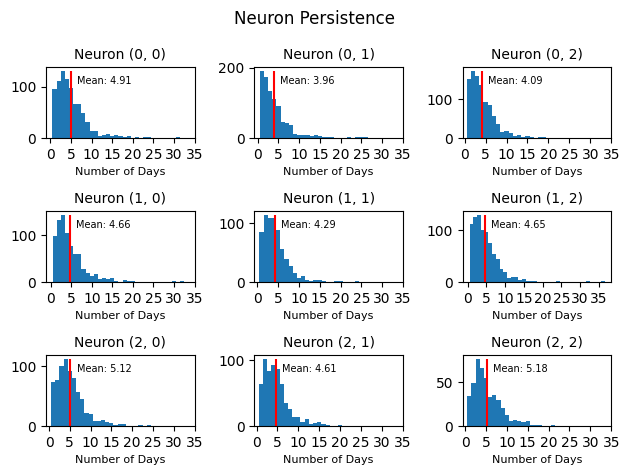

In [73]:
fig, axs = plt.subplots(n_neurons, m_neurons)

# Find the longest stretch of a consistant regime 
maxDays = max(regimePersistences.values(), key=lambda x: x[0][-1])[0][-1]

for i in range(len(neurons)):
    numDays, count = regimePersistences[neurons[i]]
    
    mean = sum(numDays * count) / sum(count)

    axs[neurons[i][0], neurons[i][1]].bar(numDays, count, width=1)
    axs[neurons[i][0], neurons[i][1]].vlines(mean, 0, max(count), label='Mean', color='red')
    axs[neurons[i][0], neurons[i][1]].text(mean + 1.5, max(count) - max(count)/5, f'Mean: {mean:.2f}', fontsize=7)
    axs[neurons[i][0], neurons[i][1]].set_xlabel('Number of Days', fontsize=8)
    axs[neurons[i][0], neurons[i][1]].xaxis.set_ticks(np.arange(0, maxDays, 5))
    axs[neurons[i][0], neurons[i][1]].set_title(f'Neuron {neurons[i]}', fontsize=10)
    
fig.suptitle('Regime Persistence')
plt.tight_layout()
plt.show()

In [ ]:
# Find the most likely next weather regime 

neuronList = []
for i, x in enumerate(dataarray):
    neuronList.append(som.winner(x))

neuronOrder = [k for k, g in itertools.groupby(neuronList)]
transitions = list(itertools.pairwise(neuronOrder))

transitions, counts = np.unique(transitions, return_counts=True, axis=0)

sortingIdxs = np.argsort(counts)[::-1]

for i in range(len(neurons)):
    neuronIdxs = np.argwhere((transitions[:, 0, 0] == neurons[i][0]) & (transitions[:, 0, 1] == neurons[i][1]))
    print(neurons[i])
    print(transitions[neuronIdxs, 1, :])
    print(counts[neuronIdxs] / sum(counts[neuronIdxs]))

transitions = transitions[sortingIdxs]
counts = counts[sortingIdxs] 


(0, 0)
[[[0 1]]

 [[0 2]]

 [[1 0]]

 [[1 1]]

 [[1 2]]

 [[2 0]]

 [[2 1]]

 [[2 2]]]
[[0.20924574]
 [0.0377129 ]
 [0.36861314]
 [0.15571776]
 [0.04987835]
 [0.03892944]
 [0.00608273]
 [0.13381995]]
(0, 1)
[[[0 0]]

 [[0 2]]

 [[1 0]]

 [[1 1]]

 [[1 2]]

 [[2 0]]

 [[2 1]]

 [[2 2]]]
[[0.33672431]
 [0.17802645]
 [0.11190234]
 [0.20142421]
 [0.06612411]
 [0.00406918]
 [0.02950153]
 [0.07222787]]
(0, 2)
[[[0 0]]

 [[0 1]]

 [[1 0]]

 [[1 1]]

 [[1 2]]

 [[2 0]]

 [[2 1]]

 [[2 2]]]
[[0.04044118]
 [0.5       ]
 [0.01470588]
 [0.09191176]
 [0.30698529]
 [0.00367647]
 [0.02205882]
 [0.02022059]]
(1, 0)
[[[0 0]]

 [[0 1]]

 [[0 2]]

 [[1 1]]

 [[1 2]]

 [[2 0]]

 [[2 1]]

 [[2 2]]]
[[0.22717842]
 [0.09647303]
 [0.01348548]
 [0.15871369]
 [0.00622407]
 [0.36514523]
 [0.07780083]
 [0.05497925]]
(1, 1)
[[[0 0]]

 [[0 1]]

 [[0 2]]

 [[1 0]]

 [[1 2]]

 [[2 0]]

 [[2 1]]

 [[2 2]]]
[[0.10132576]
 [0.19791667]
 [0.0530303 ]
 [0.18939394]
 [0.11268939]
 [0.08712121]
 [0.15625   ]
 [0.10227273]]
